In [41]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.5em;
line-height:1.4em;
padding-left:3em;
padding-right:3em;
}
</style>
""")

# Задача "Бинарные данные"

http://mlbootcamp.ru/round/6/sandbox/

![](http://saturdayjam.ru/lj/b036.jpg)


### Постановка задачи

Дано 30 бинарных признаков и 3 целевых класса. В качестве критерия качества решения задачи будет приниматься **точность** классификации, т.е. доля правильно классифицированных объектов.

In [174]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib import cm # импортируем цветовые схемы, чтобы рисовать графики.
plt.rcParams['figure.figsize'] = 12, 8 # увеличиваем размер картинок
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.api as sm

In [3]:
def read_train():
    X_train = pd.read_csv('data_public/x_train.csv', header=None)
    Y_train = pd.read_csv('data_public/y_train.csv', header=None, names=['target'])
    data = pd.concat([X_train, Y_train], axis=1)
    return data, X_train, Y_train.target

In [4]:
data, X_train, Y_train = read_train()
print(data.shape)
data.head()

(210, 31)


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,target
0,1,1,1,1,0,0,0,1,0,0,...,1,1,1,1,0,1,1,0,1,1
1,1,0,1,0,0,0,1,1,0,1,...,1,1,0,1,0,0,1,0,0,1
2,0,1,1,0,0,0,0,1,1,1,...,1,0,0,1,1,1,0,1,0,1
3,1,0,1,1,0,1,0,1,1,0,...,1,0,0,1,0,1,1,1,0,0
4,1,1,0,0,1,0,0,1,0,1,...,1,0,1,1,1,1,0,1,1,2


In [5]:
# проверим пропуски и то как распределены значения признаков
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,target
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,...,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,0.390476,0.523810,0.528571,0.504762,0.500000,0.538095,0.495238,0.547619,0.504762,0.514286,...,0.542857,0.504762,0.533333,0.495238,0.438095,0.519048,0.452381,0.557143,0.438095,1.033333
std,0.489023,0.500626,0.500376,0.501172,0.501195,0.499738,0.501172,0.498917,0.501172,0.500990,...,0.499350,0.501172,0.500080,0.501172,0.497339,0.500831,0.498917,0.497911,0.497339,0.820686
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,1.000000,0.500000,1.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [63]:
def examine(clf, X, y):
    cv = StratifiedKFold(n_splits=5)
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("{}. Score: {} (+/- {})".format(clf.__class__.__name__,scores.mean(), scores.std() * 2))

In [64]:
clf = LogisticRegression()
examine(clf, X_train, Y_train)

LogisticRegression. Score: 0.39528864005287767 (+/- 0.0678279839014812)


In [20]:
clf = DummyClassifier()
examine(clf, X_train, Y_train)

Score: 0.3422885136908407 (+/- 0.1152291878713352)


In [22]:
clf = XGBClassifier()
examine(clf, X_train, Y_train)

Score: 0.3948191564848025 (+/- 0.10276228045050986)


# WAT?

DummyClassifier ~ LogisticRegression ~ **XGBoost**!!! ~> 38% точности?

![](http://www.kino-mira.ru/images/stories/zanimatelnie-fakty/matrix-final/udar.gif)

## В любой непонятной ситуации - думай!

Для начала посмотрим на соотношение классов. И судя по графикам, всё весьма хорошо - можно сказать, что классы сбалансированы.

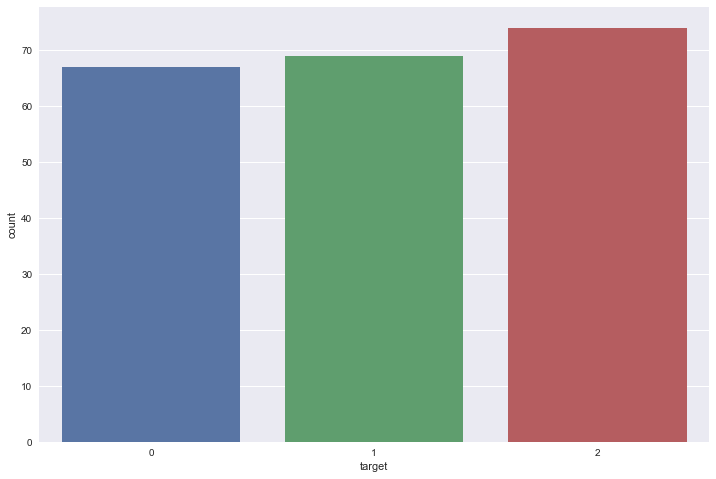

In [23]:
sns.countplot(data=data, x='target')

Логично посмотреть на форму распределения признаков по каждому классу.

Строим для каждого элемента выборки график по его бинарным признакам. Разделим по цветам 3 разных класса. Чем чаще линия проходит через одни и те же точки, тем на графике она более толстая. По оси ординат откладывается среднее значение для данного класса принимать определенное значение признака.

Из графика видно, что в целом есть некоторые отличия в средних значениях, но в целом основная масса находится в середине. Отсюда можно сделать предположение, что признаки хорошо выровнены.

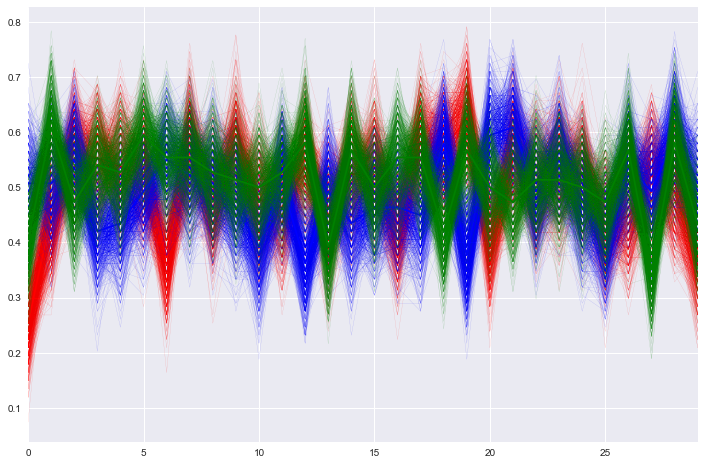

In [24]:
points = [[],[],[]]
for j in range(3):
    for row in data[data['target'] == j].drop(['target'], axis=1).iterrows():
         points[j].append(row[1])

colors = ['red', 'blue', 'green']
for j in range(3):
    sns.tsplot(points[j], err_style="boot_traces", n_boot=800, color=colors[j])

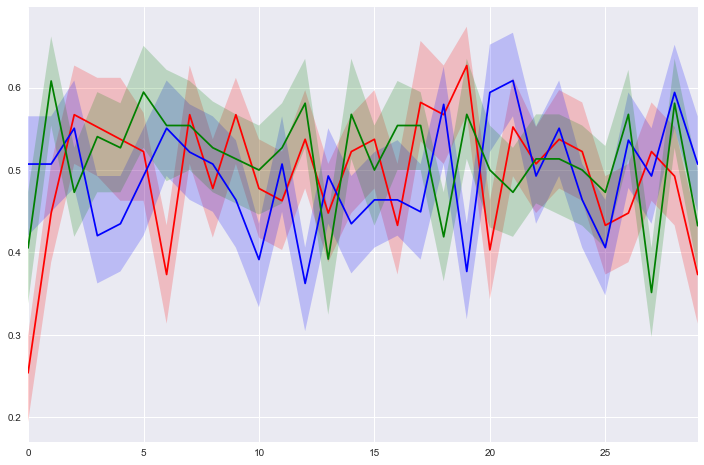

In [25]:
colors = ['red', 'blue', 'green']
for j in range(3):
    sns.tsplot(points[j], n_boot=200, color=colors[j])

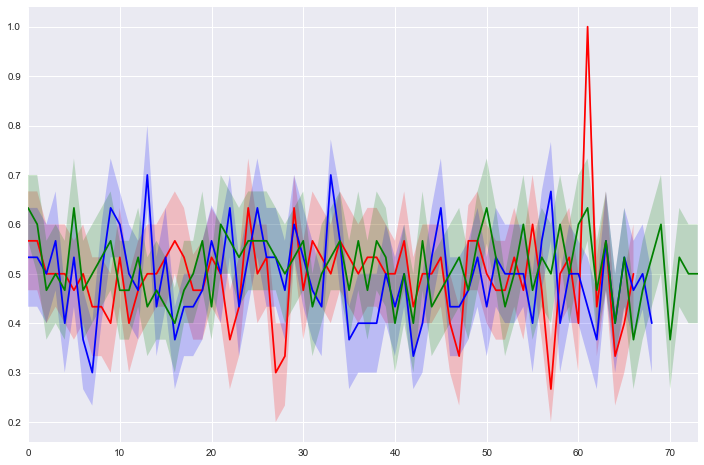

In [72]:
points = [[],[],[]]
for j in range(3):
    for row in data[data['target'] == j].drop(['target'], axis=1).T.iterrows():
         points[j].append(row[1])

colors = ['red', 'blue', 'green']
for j in range(3):
    sns.tsplot(points[j], n_boot=800, color=colors[j])

# Среднее по всем строкам

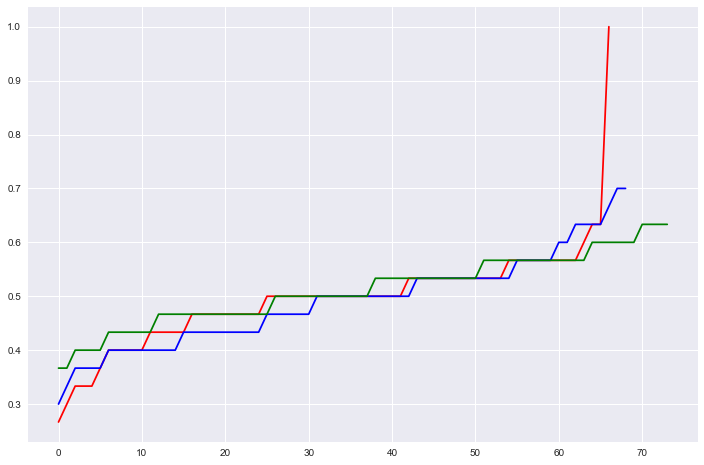

In [84]:
for j in range(3):
    x = data[data['target'] == j].drop(['target'], axis=1)
    plt.plot(x.mean(axis=1).sort_values().reset_index()[0], color=colors[j])

Такое ощущение, что синий график как будто немного тяжелее, чем зеленый и красный вместе. Это наверное как-то отражает внутреннюю структуру данных.

## Взаимная корреляции

> Cтандартный метод оценки степени корреляции двух последовательностей. Она часто используется для поиска в длинной последовательности более короткой заранее известной. Значительная корреляция между двумя случайными величинами всегда является свидетельством существования некоторой статистической связи в данной выборке, но эта связь не обязательно должна наблюдаться для другой выборки и иметь причинно-следственный характер.

Судя по графику признаки вообще почти не коррелируют друг с другом и с целевой переменной. Это очень странно.

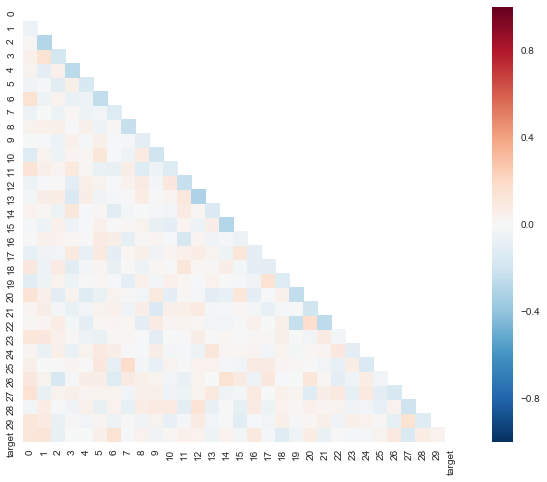

In [45]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(corr, square=True, mask=mask)

# Статистические характеристики

![](http://fotki.ykt.ru/albums/userpics/16462/42_0212.jpg)

Если мы не знаем ничего про данные, то логично посмотреть на статистику по этим данным.

- **Эксцесс** (kurtosis)

Это мера остроты пика распределения случайной величины. Коэффициент эксцесса равен 0 для нормального распределения.

$$\gamma_2 = \frac{\mu_4}{\sigma^4}-3$$

- **среднее** - первый момент
- **дисперсия** - второй момент
- **ассиметрия** - третий момент. Коэффициент асимметрии положителен, если правый хвост распределения длиннее левого, и отрицателен в противном случае.

$$\gamma_1 = \frac{\mu_3}{\sigma^3}$$

- **энтропия** - мера неопределенности
- **нормальность** - специальный статистический тест, учитывающий эксцесс и ассиметрию, чтобы определить, похоже ли распределение на нормальное или нет.

In [48]:
def prepare_statistics(X_train, Y_train):
    d = pd.DataFrame(index=X_train.index)
    d['target'] = Y_train
    d['kurtosis'] = X_train.kurtosis(axis=1)
    d['entropy'] = X_train.apply(lambda row: stats.entropy(row), axis=1)
    d['std'] = X_train.std(axis=1)
    d['skew'] = X_train.skew(axis=1)
    d['normal_stat'] = X_train.apply(lambda row: stats.normaltest(row)[0], axis=1)
    d['mean'] = X_train.mean(axis=1)
    return d

d = prepare_statistics(X_train, Y_train)
d.head()

,target,kurtosis,entropy,std,skew,normal_stat,mean
0,1,-2.126913,2.772589,0.507416,-0.140769,222.464936,0.533333
1,1,-2.126913,2.772589,0.507416,-0.140769,222.464936,0.533333
2,1,-2.148148,2.708050,0.508548,0.000000,279.252501,0.500000
3,0,-2.062056,2.833213,0.504007,-0.283443,132.604517,0.566667
4,2,-1.784005,2.944439,0.490133,-0.582933,37.087925,0.633333


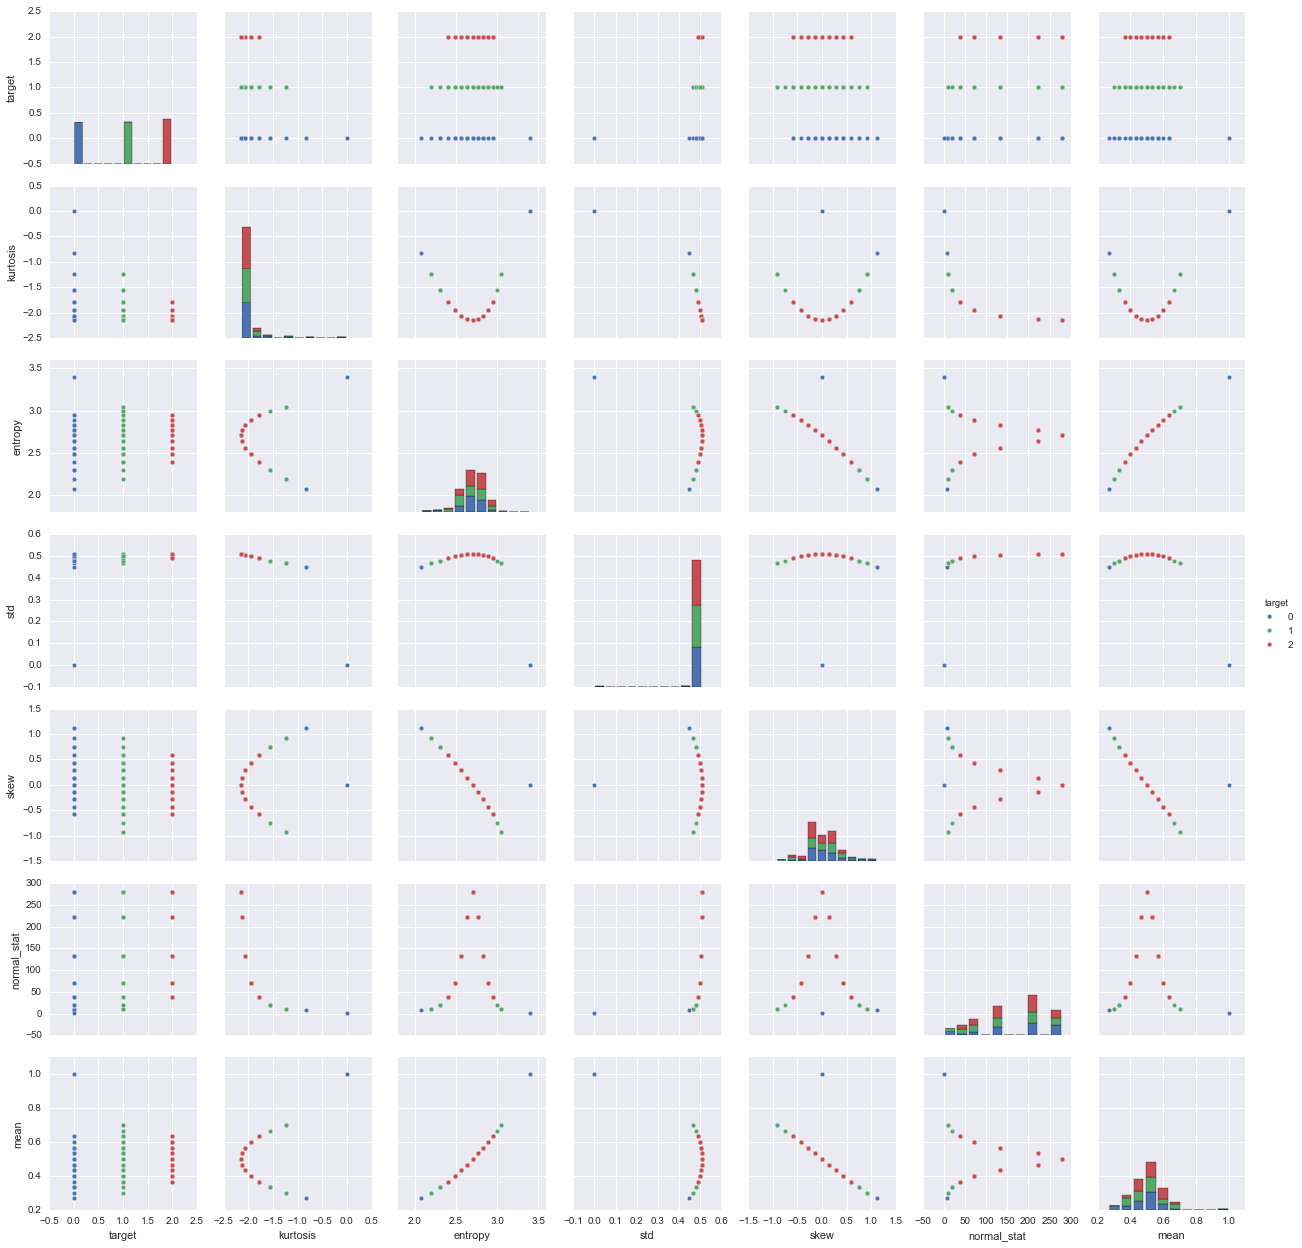

In [31]:
sns.pairplot(d, hue='target')

In [36]:
X = d.drop(['target', 'std', 'normal_stat', 'mean', 'skew'], axis=1)
Y = d['target']
X.head(2)

,kurtosis,entropy
0,-2.126913,2.772589
1,-2.126913,2.772589


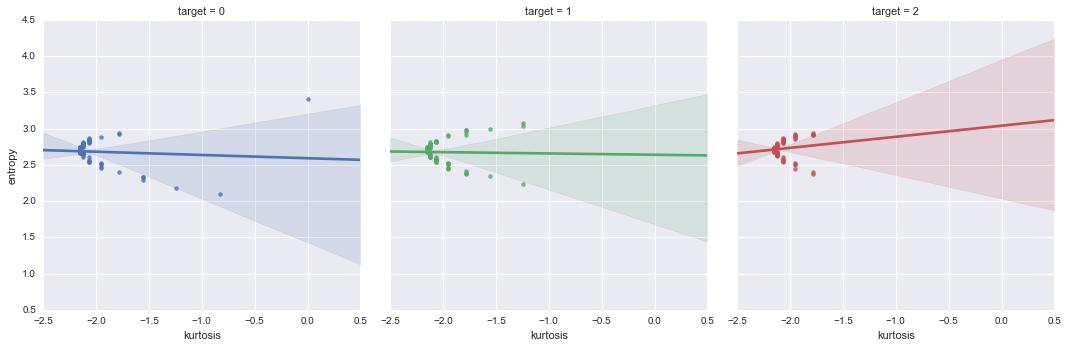

In [17]:
sns.lmplot(x='kurtosis', y='entropy', col='target', hue='target', data=d, y_jitter=.04)

In [37]:
clf = XGBClassifier(max_depth=2, n_estimators=60)
examine(clf, X, Y)

Score: 0.4333877662107913 (+/- 0.09466514544613586)


In [24]:
def knn(X, y):
    clf = KNeighborsClassifier()
    params = {
        'n_neighbors': [5, 8, 9, 10, 11, 12, 13, 14,15,16,17,18,19,20], 
        'metric': ['hamming', 'jaccard', 'minkowski'],
        'weights': ['uniform', 'distance']}
    grid_search = GridSearchCV(clf, param_grid=params, cv=StratifiedKFold(5, random_state=42), scoring='accuracy')
    grid_search.fit(X, y)
    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    return grid_search

In [38]:
knn(X, Y)

Best score: 0.45714285714285713
Best parameters: {'n_neighbors': 10, 'metric': 'minkowski', 'weights': 'uniform'}


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'metric': ['hamming', 'jaccard', 'minkowski'], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

# Эксцесс + энтропия = ❤️

Достаточно только коэффициента эксцесса и энтропии для того, чтобы улучшить предсказание на 0.06!
Интересно, что тогда это за данные, что для них главными признаками становятся статистиеские критерии?
Может быть это на самом деле случайные числа? Может это белый шум?

# Нужно больше статистики 👽

- Тест Дики — Фуллера - проверка ряда на стационарность (если все его вероятностные характеристики не меняются с течением времени t)
- Критерий Стьюдента - проверка равенства средних двух выборок. Распределение в выборках должно быть близко к нормальному.
- erfc - Дополнительная функция ошибок - показывает вероятность с которой число отклонится от среднего на `a`. 
- И так далее.

Но нужны ли нам эти непонятные статистики? Выглядит так, что мы хотим просто натянуть разные магические формулы на данные и ожидаем чуда. Поэтому предлгаю пока отложить эти размышления.

# Что такое признаки?

Признаки бывают разные: числовые, категориальные, бинарные и другие.

Основное допущение о признаках в классичесом ML - порядок признаков не важен. Можно делать подвыборки признаков. Признаки могуткоррелировать, быть линейно выраженными друг через друга...

А что если??

![](https://s3-eu-west-1.amazonaws.com/userlike-cdn-blog/phrases-not-to-say/not-sure.jpg)

In [69]:
# Для перебора разных алгоритмов и обнаружить улучшение сделаем специальный кросс валидатор

def examine_all(df):
    X = df.drop(['target'],axis=1)
    y = df['target']
    clfs = [XGBClassifier(n_estimators=300), LogisticRegression(), KNeighborsClassifier(n_neighbors=10), RidgeClassifier()]
    for clf in clfs:
        examine(clf, X, y)

In [72]:
# Это сырые данные
examine_all(data)

XGBClassifier. Score: 0.4186306243256641 (+/- 0.08531809819975278)
LogisticRegression. Score: 0.39528864005287767 (+/- 0.0678279839014812)
KNeighborsClassifier. Score: 0.45679098747071806 (+/- 0.13584861733354633)
RidgeClassifier. Score: 0.4188989006502785 (+/- 0.04240565166917508)


# Гипотеза

А что если нам важен порядок признаков? Как будто это последовательнось отсчетов? Между собой они не коррелируют(или нам так кажется), но в этой последовательности есть ЗАКОНОМЕРНОСТЬ. Допустим это некоторый ряд.

## Методы проверки

- смотреть на фичи как на одно большое слово и сделать CountVectorizer с n-k-skip граммами.
- оценивать максимально длинные подпоследовательности нулей и единиц.
- как часто меняются символы в последовательности

# Switchness - "переменность"

Как часто в ряде меняетс 1 на 0 и наоборот. Мне напоминает манчестерское кодирование сигнала, которое используется в Ethernet.

```python
switchness([1,0,0,1,1,0,1,0,1,1])==7
```

In [47]:
def r(a,b):
    if (a == b):
        return 0
    else:
        return 1
    
def switchness(seq):
    return np.sum([r(seq[i], seq[i+1]) for i in range(len(seq)-1)]) + 1

assert(switchness([1,0,0,1,1,0,1,0,1,1])==7)
assert(switchness([1,1,1,1,1,1,1,1,1,1])==1)
assert(switchness([1,0,1,0,1,0,1,0,1,0])==10)

In [54]:
d = pd.DataFrame(index=X_train.index)
d['switchness'] = X_train.apply(lambda row: switchness(row), axis=1)
d['target'] = Y_train
d.head()

,switchness,target
0,15,1
1,20,1
2,19,1
3,20,0
4,19,2


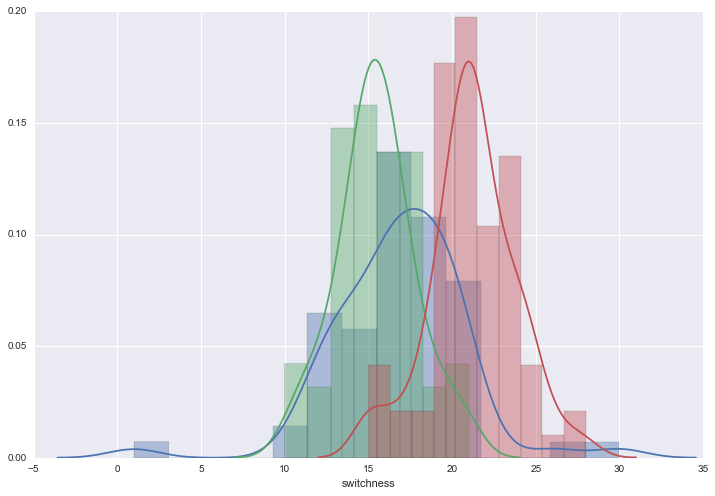

In [58]:
plt.rcParams['figure.figsize'] = 12, 8
for j in range(3):
    sns.distplot(d[d['target'] == j]['switchness'])

На графике распределения "переменности" мы видим 3 разные гаусианы с разными центрами и высотой пиков. Кажется что теперь проще разделить последовательности!!

In [70]:
examine_all(d)

XGBClassifier. Score: 0.5423827992107233 (+/- 0.11512836037920109)
LogisticRegression. Score: 0.5668095529699938 (+/- 0.05294767720166427)
KNeighborsClassifier. Score: 0.5666064016951954 (+/- 0.02893094099567795)
RidgeClassifier. Score: 0.6047725969342626 (+/- 0.07408541956143493)


ТОЛЬКО лишь **Switchness** даёт качество предсказания в среднем 0.57!! Заметим это лишь один признак. Кажется мы идем правильным путём.

## Самая длинная подпоследовательность

Можно  каждом семпле смотреть длину непрекращающейся подпоследовательности.

In [95]:
def longest_seq(seq):
    return np.max([len(sub) for sub in "".join([str(i) for i in seq]).split('0')])
def longest_seq_sum(seq):
    return np.sum([len(sub) for sub in "".join([str(i) for i in seq]).split('0')])
def longest_seq_mean(seq):
    return np.mean([len(sub) for sub in "".join([str(i) for i in seq]).split('0')])
assert(longest_seq([1,1,1,0,1,0,1,1])==3)

In [110]:
d = pd.DataFrame(index=X_train.index)
d['longest_seq'] = X_train.apply(lambda row: longest_seq(row), axis=1)
d['longest_seq_sum'] = X_train.apply(lambda row: longest_seq_sum(row), axis=1)
#d['longest_seq_mean'] = X_train.apply(lambda row: longest_seq_mean(row), axis=1)
d['target'] = Y_train
d.head()

,longest_seq,longest_seq_sum,target
0,5,16,1
1,3,16,1
2,3,15,1
3,3,17,0
4,4,19,2


In [111]:
examine_all(d)

XGBClassifier. Score: 0.5040115086655197 (+/- 0.13990332038488412)
LogisticRegression. Score: 0.4524412173524237 (+/- 0.028771793707507792)
KNeighborsClassifier. Score: 0.41386871956375937 (+/- 0.09335169807099498)
RidgeClassifier. Score: 0.47148883640004274 (+/- 0.08138563473691714)


## Count vectorizer

Посмотрим на данные как на слова и применим алгоритмы анализа текстов. Рассмотрим всевозмодные n-gramm по символам.

Напомню что n-gramm это когда по предложению "мама мыла раму" составляют комбинации "мама мыла", "мыла раму".

In [88]:
v = CountVectorizer(ngram_range=(2,3))
print(v.fit(["an apple a day keeps the doctor away"]).vocabulary_)

{'an apple day': 1, 'day keeps': 4, 'keeps the': 7, 'apple day keeps': 3, 'keeps the doctor': 8, 'an apple': 0, 'the doctor': 9, 'doctor away': 6, 'day keeps the': 5, 'apple day': 2, 'the doctor away': 10}


In [74]:
def count_vec(df):
    word = data.apply(lambda row: ''.join([str(c) for c in row]), axis=1)
    vec = CountVectorizer(analyzer='char', ngram_range=(6,8))
    bag = pd.DataFrame(vec.fit_transform(word).toarray())
    return bag

In [82]:
d = count_vec(X_train)
d['target'] = Y_train
d.head()

,0,1,2,3,4,5,6,7,8,9,...,555,556,557,558,559,560,561,562,563,target
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [81]:
examine_all(d)

XGBClassifier. Score: 0.6040921859660378 (+/- 0.13716898859226676)
LogisticRegression. Score: 0.6230766239951788 (+/- 0.12874205492450877)
KNeighborsClassifier. Score: 0.5897355145364943 (+/- 0.1587966139288223)
RidgeClassifier. Score: 0.6278385287570836 (+/- 0.13232333950430175)


## Объединим лучшие признаки!

![](http://cs4.pikabu.ru/post_img/big/2016/07/23/12/1469304016155364069.jpg)

In [122]:
d = pd.DataFrame(index=X_train.index)
d['switchness'] = X_train.apply(lambda row: switchness(row), axis=1)
d['longest_seq'] = X_train.apply(lambda row: longest_seq(row), axis=1)
d['longest_seq_sum'] = X_train.apply(lambda row: longest_seq_sum(row), axis=1)
d['target'] = Y_train

examine_all(d)

XGBClassifier. Score: 0.5048299458587272 (+/- 0.017746354112315888)
LogisticRegression. Score: 0.5570787041087102 (+/- 0.08164730867222256)
KNeighborsClassifier. Score: 0.566943691132301 (+/- 0.09925818428621683)
RidgeClassifier. Score: 0.6046384587719554 (+/- 0.03991989619752975)


Качество ухудшилось, точнее ограничилось худшим из признаков!

Что делать? - Искать комбинации.

![](http://risovach.ru/upload/2017/01/mem/ya-konechno-ne-budu_133807654_orig_.jpg)

In [143]:
d = pd.DataFrame(index=X_train.index)
d['switchness'] = X_train.apply(lambda row: switchness(row), axis=1)
#d['longest_seq'] = X_train.apply(lambda row: longest_seq(row), axis=1)
d['longest_seq_sum'] = X_train.apply(lambda row: longest_seq_sum(row), axis=1)
d['target'] = Y_train

examine_all(d)

XGBClassifier. Score: 0.5857939909991349 (+/- 0.013667074280615239)
LogisticRegression. Score: 0.5521807171531605 (+/- 0.07584283439830447)
KNeighborsClassifier. Score: 0.5953848696040981 (+/- 0.053254588524750075)
RidgeClassifier. Score: 0.5810281981745545 (+/- 0.06848150186566689)


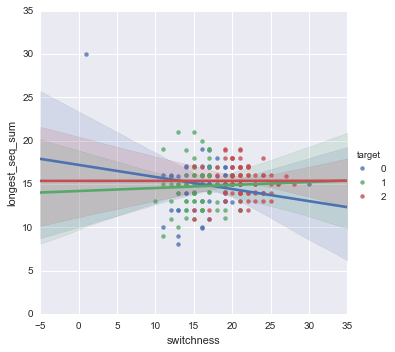

In [141]:
sns.lmplot(x='switchness', y='longest_seq_sum', hue='target', data=d, y_jitter=.04)

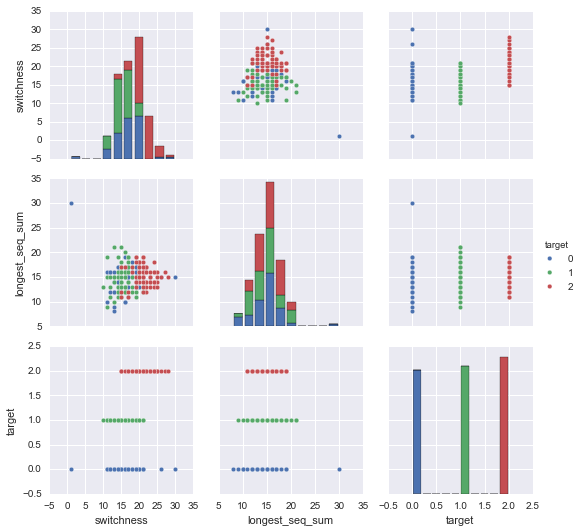

In [145]:
sns.pairplot(d, hue='target')

In [199]:
d = count_vec(X_train)
d['switchness'] = X_train.apply(lambda row: switchness(row), axis=1)
d['longest_seq_sum'] = X_train.apply(lambda row: longest_seq_sum(row), axis=1)
d['entropy'] = X_train.apply(lambda row: stats.entropy(row), axis=1)
d['kurtosis'] = X_train.kurtosis(axis=1)
d['mean'] = X_train.mean(axis=1)
d['student'] = X_train.apply(lambda row: stats.ttest_1samp(row,0)[1], axis=1)
d['freq_bitwise_test'] = X_train.apply(lambda row: erfc((2.0*np.sum(row) - row.size) / np.sqrt(row.size)), axis=1)

d['target'] = Y_train

examine_all(d)

XGBClassifier. Score: 0.6421913121239515 (+/- 0.15306575144307535)
LogisticRegression. Score: 0.6372952691997394 (+/- 0.1454121780140428)
KNeighborsClassifier. Score: 0.6226664333829062 (+/- 0.2077767322927751)
RidgeClassifier. Score: 0.5898064716803235 (+/- 0.11993769484140733)


In [200]:
def extract_features(df):
    d = count_vec(df)
    d['switchness'] = df.apply(lambda row: switchness(row), axis=1)
    d['longest_seq_sum'] = df.apply(lambda row: longest_seq_sum(row), axis=1)
    d['entropy'] = df.apply(lambda row: stats.entropy(row), axis=1)
    d['kurtosis'] = df.kurtosis(axis=1)
    d['mean'] = X_train.mean(axis=1)
    d['student'] = X_train.apply(lambda row: stats.ttest_1samp(row,0)[1], axis=1)
    d['freq_bitwise_test'] = X_train.apply(lambda row: erfc((2.0*np.sum(row) - row.size) / np.sqrt(row.size)), axis=1)
    return d

In [164]:
X_test = pd.read_csv('data_public/x_test.csv', header=None)

In [201]:
X_train_prepared = extract_features(X_train)
X_test_prepared = extract_features(X_test)

In [202]:
knn(X_train_prepared, Y_train)

Best score: 0.638095238095238
Best parameters: {'n_neighbors': 12, 'metric': 'minkowski', 'weights': 'distance'}


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'metric': ['hamming', 'jaccard', 'minkowski'], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [204]:
clf = VotingClassifier([
    ("xgb", XGBClassifier(n_estimators=300)), 
    ("knn", KNeighborsClassifier(n_neighbors=12,weights='distance')), 
    ("lin", LogisticRegression())], voting='soft')

examine(clf, X_train_prepared, Y_train)

VotingClassifier. Score: 0.6326694466314796 (+/- 0.1189782118680593)


## Итог

### Сырые данные

Dummy = 0.34

XGB, Linear = 0.39

### Статистики

XGB = 0.43

KNN = 0.46

### Подпоследовательность

0.51

### Switchness

0.56

### Count vectorizer

0.61

### Final

0.64


![](http://www.unilad.co.uk/wp-content/uploads/2015/08/J6Gzst1fU.jpg)

In [205]:
clf.fit(X_train_prepared, Y_train)
pred = clf.predict(X_test_prepared)

In [206]:
submission = pd.DataFrame(pred, index=X_test.index)
submission.to_csv('submission_7.csv', header=False, index=False)